# Project 2: Clustering
**ECE 219**: Large-Scale Data Mining: Models and Algorithms [Winter 2021]

Prof. Vwani Roychowdhury

UCLA, Department of ECE

**Due**: 2021.02.23 11:59PM PT

In [37]:
from sklearn.datasets import fetch_20newsgroups
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import string
import urllib
import zipfile
import sys

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=4, suppress=True)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Q1

Building the TF-IDF matrix.

Following the steps in Project 1, transform the documents into TF-IDF vectors.

Use min_df = 3, exclude the stopwords (no need to do stemming or lemmatization), and remove the headers and footers.

Report the dimensions of the TF-IDF matrix you get.

**ANSWER**

```
inputs_tfidf.shape: (7882, 27768)
```

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
categories = [
    'comp.graphics', 
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware', 
    'comp.sys.mac.hardware',
    'rec.autos', 
    'rec.motorcycles',
    'rec.sport.baseball', 
    'rec.sport.hockey'
]

news_data = fetch_20newsgroups(
    subset='all',
    categories=categories,
    shuffle=True, 
    random_state=RANDOM_SEED,
    remove=('header', 'footer')
)

inputs = news_data.data
labels = news_data.target // 4

target_names = ['Computer Technology', 'Recreational Activity']

In [6]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, stop_words='english')

inputs_tfidf = tfidf_vectorizer.fit_transform(inputs)
print("inputs_tfidf.shape:", inputs_tfidf.shape)

inputs_tfidf.shape: (7882, 27768)


## Q2

Report the contingency table of your clustering result. You may use the provided `plotmat.py` to visualize the matrix.

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (
    contingency_matrix, 
    homogeneity_score, 
    v_measure_score, 
    completeness_score, 
    adjusted_rand_score, 
    adjusted_mutual_info_score
)
from plotmat import plot_mat

In [13]:
km = KMeans(
    n_clusters=2, 
    random_state=0,
    max_iter=5000,
    n_init=50
)
preds = km.fit_predict(inputs_tfidf)

Contingency table: 
 [[   4 3899]
 [1717 2262]]


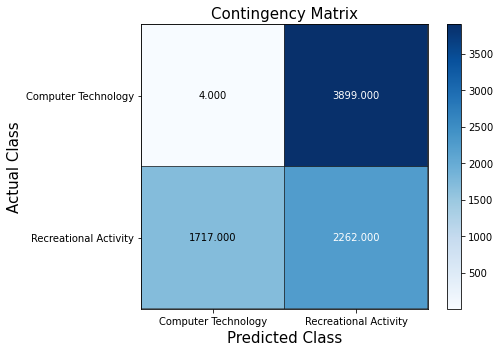

In [14]:
A = contingency_matrix(labels, preds)
print("Contingency table: \n", A)
plot_mat(
    mat=A, 
    size=(7,5),
    xlabel='Predicted Class',
    ylabel='Actual Class',
    xticklabels=target_names,
    yticklabels=target_names,
    title='Contingency Matrix'
)

## Q3

Report the 5 measures above for the K-means clustering results you get.

In [15]:
def get_cluster_metrics(y_true, y_pred, metrics=None):
    if not metrics:
        metrics = [
            homogeneity_score,
            completeness_score,
            v_measure_score,
            adjusted_rand_score,
            adjusted_mutual_info_score
        ]
    d = {}
    for m in metrics:
        d[m.__name__] = m(y_true, y_pred)
    df = pd.DataFrame(d, index=[0]).T
    df.reset_index(inplace=True)
    df.rename(columns={'index':'metric', 0:'score'}, inplace=True)
    return df

In [16]:
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.253413
1,completeness_score,0.334677
2,v_measure_score,0.288430
3,adjusted_rand_score,0.180546
4,adjusted_mutual_info_score,0.288356


## Q4

Report the plot of the percent of variance the top r principle components can retain v.s. $r$, for $r \in \{1...1000\}$.

In [17]:
from sklearn.decomposition import TruncatedSVD

In [22]:
svd = TruncatedSVD(n_components=1000,random_state=RANDOM_SEED)
inputs_svd = svd.fit_transform(inputs_tfidf)

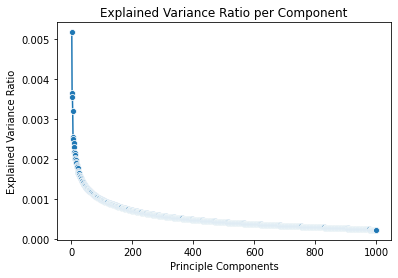

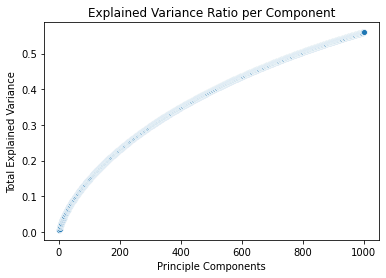

In [55]:
xs = np.arange(1,1001)
ys = sorted(svd.explained_variance_ratio_, reverse=True)
ys_cum = np.cumsum(svd.explained_variance_ratio_)

g = sns.lineplot(
    x=xs, 
    y=ys,
    marker='o'
)
g.set_xlabel('Principle Components')
g.set_ylabel('Explained Variance Ratio')
g.set_title('Explained Variance Ratio per Component')
plt.show()

g = sns.lineplot(
    x=xs, 
    y=ys_cum,
    marker='o'
)
g.set_xlabel('Principle Components')
g.set_ylabel('Total Explained Variance')
g.set_title('Explained Variance Ratio per Component')
plt.show()


## Q5

Let $r$ be the dimension that we want to reduce the data to (i.e. n_components).
Try $r \in \{1, 2, 3, 5, 10, 20, 50, 100, 300\}$, and plot the 5 measure scores v.s. $r$ for both
SVD and NMF.

Report a good choice of r for SVD and NMF respectively.

**ANSWER**

$r=2$ is the best choice for both SVD and NMF.

In [89]:
from sklearn.decomposition import NMF

In [98]:
km = KMeans(
    n_clusters=2, 
    random_state=0,
    max_iter=5000,
    n_init=50
)

n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300]

### SVD-Reduced Data

In [99]:
scores = []
for r in n_components:
    inputs_svd = TruncatedSVD(n_components=r, random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_svd)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.000271,0.000275,0.000273,0.000296,0.000181
2,0.577167,0.579872,0.578517,0.672517,0.578478
3,0.413470,0.448835,0.430427,0.414009,0.430373
5,0.222218,0.310361,0.258995,0.145737,0.258916
10,0.234625,0.321219,0.271177,0.157799,0.271100
20,0.236404,0.322558,0.272841,0.159822,0.272765
50,0.242165,0.326171,0.277960,0.167420,0.277884
100,0.245914,0.329721,0.281717,0.170760,0.281641
300,0.241949,0.326734,0.278022,0.166176,0.277946


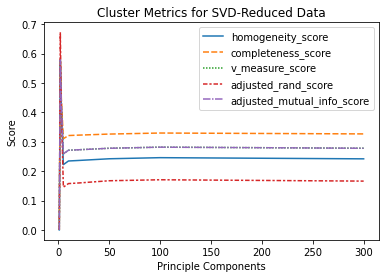

In [100]:
g = sns.lineplot(data=metrics_df)
g.set_xlabel('Principle Components')
g.set_ylabel('Score')
g.set_title('Cluster Metrics for SVD-Reduced Data')
plt.show()

### NMF-Reduced Data

In [101]:
scores = []
for r in n_components:
    inputs_nmf = NMF(n_components=r, init='random', random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_nmf)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.000271,0.000275,0.000273,0.000296,0.000181
2,0.582552,0.599296,0.590806,0.634364,0.590768
3,0.027821,0.155780,0.047211,0.003928,0.047063
5,0.375401,0.433068,0.402178,0.341705,0.402119
10,0.092525,0.215844,0.129527,0.033742,0.129415
20,0.001860,0.002471,0.002122,0.001201,0.002018
50,0.008735,0.013233,0.010523,0.005683,0.010414
100,0.003617,0.005938,0.004496,0.001795,0.004382
300,0.002161,0.003253,0.002597,0.001114,0.002487


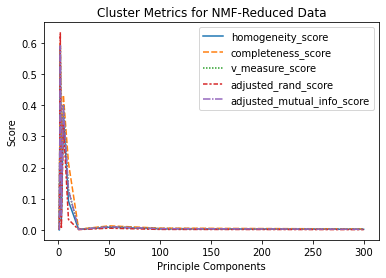

In [102]:
g = sns.lineplot(data=metrics_df)
g.set_xlabel('Principle Components')
g.set_ylabel('Score')
g.set_title('Cluster Metrics for NMF-Reduced Data')
plt.show()

## Q6

How do you explain the non-monotonic behavior of the measures as $r$ increases?

**ANSWER**

At $r=1$, the distances are hard to differentiate from one another as there is only 1 dimension to "travel." Allowing for $r=2$ provides for a larger space for the points to be projected upon and therefore easier to distinguish via K-Means. However, as $r$ continues to increase and therefore the dimensionality increases, the default Euclidean distance measure becomes less and less capable of providing an intuitive sense of separation. The aptly named "Curse of Dimensionality" strikes and unless we use a different measure of distance, we are better off sticking with $r=2$.

## Q7

Visualize the clustering results for:
* SVD with your choice of $r$
* NMF with your choice of $r$

In [125]:
r = 2

inputs_svd = TruncatedSVD(n_components=r, random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
km_svd = KMeans(n_clusters=2, random_state=RANDOM_SEED, max_iter=5000, n_init=50)
preds_svd = km_svd.fit_predict(inputs_svd)

inputs_nmf = NMF(n_components=r, init='random', random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
km_nmf = KMeans(n_clusters=2, random_state=RANDOM_SEED, max_iter=5000, n_init=50)
preds_nmf = km_nmf.fit_predict(inputs_nmf)

svd_df = pd.DataFrame(inputs_svd, columns=['pc1', 'pc2'])
nmf_df = pd.DataFrame(inputs_nmf, columns=['pc1', 'pc2'])

svd_df['labels'] = labels
nmf_df['labels'] = labels

svd_df['preds'] = preds_svd
nmf_df['preds'] = preds_nmf

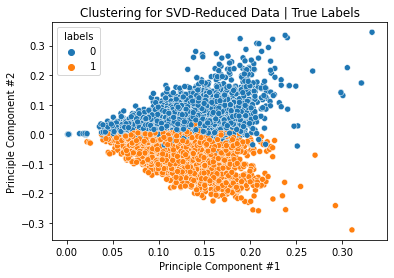

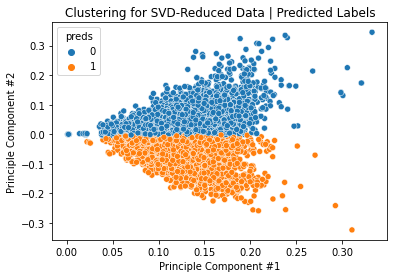

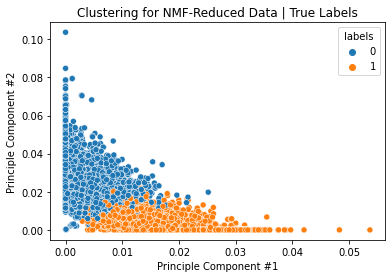

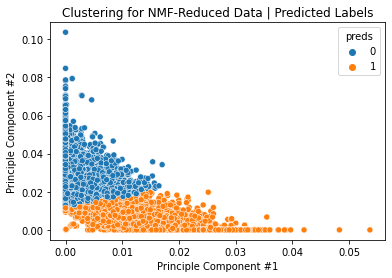

In [129]:
g = sns.scatterplot(x='pc1', y='pc2', hue='labels', data=svd_df)
g.set_xlabel('Principle Component #1')
g.set_ylabel('Principle Component #2')
g.set_title('Clustering for SVD-Reduced Data | True Labels')
plt.show()

g = sns.scatterplot(x='pc1', y='pc2', hue='preds', data=svd_df)
g.set_xlabel('Principle Component #1')
g.set_ylabel('Principle Component #2')
g.set_title('Clustering for SVD-Reduced Data | Predicted Labels')
plt.show()

g = sns.scatterplot(x='pc1', y='pc2', hue='labels', data=nmf_df)
g.set_xlabel('Principle Component #1')
g.set_ylabel('Principle Component #2')
g.set_title('Clustering for NMF-Reduced Data | True Labels')
plt.show()

g = sns.scatterplot(x='pc1', y='pc2', hue='preds', data=nmf_df)
g.set_xlabel('Principle Component #1')
g.set_ylabel('Principle Component #2')
g.set_title('Clustering for NMF-Reduced Data | Predicted Labels')
plt.show()

## Q8

What do you observe in the visualization? How are the data points of the two classes distributed? Is the data distribution ideal for K-Means clustering?

**ANSWER**

KMeans makes 3 primary assumptions:
1. the feature distributions are spherical
2. the features have similar variance
3. there are approximately the same number of examples from each class. 

If any of these assumptions are violated, KMeans will  underperform. Unfortunately, the plots show that the feature distributions are not spherical. There are also no separable or distinct clusters for KMeans to assign. Much of the data overlaps in the reduced dimension.  